# Prototype: Alpha

| Properties      | Data    |
|---------------|-----------|
| *Labels* | `['BENIGN', 'DDoS']` |
| *Normalization* | `Min-Max` |
| *Sample Size* | `2000`|
| *Adversarial Attack* | `FGSM` |
| *Explanations* | `SHAP` |


---

In [2]:
# To import modules from the functions directory
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

## Data Preprocessing

In [3]:
import functions.data_preprocessing as dp
import importlib
importlib.reload(dp)

encoding_type = 0 # binary encoding
norm_type = 0 # min-max normalization
label_names = ['BENIGN', 'DDoS'] # labels to include
sample_size = 1000 # sample size for each label

dataset = dp.build_dataset(label_names)

normalizer, zero_columns = dp.generate_normalizer(dataset, norm_type)

feature_df, label_df = dp.preprocess_data(dataset, encoding_type, normalizer, zero_columns, sample_size, 42)
print(label_df.value_counts())

-- Building CICIDS2017 dataset --
--- Combining all CICIDS2017 files ---
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Friday-WorkingHours-Morning.pcap_ISCX.csv
Monday-WorkingHours.pcap_ISCX.csv
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Tuesday-WorkingHours.pcap_ISCX.csv
Wednesday-workingHours.pcap_ISCX.csv
--- Removing NaN and Infinity values ---
Removing 1358 Rows with NaN values
Removing 1509 Rows with Infinity values
--- Extracting labels ---
 Label
BENIGN    2271320
DDoS       128025
Name: count, dtype: int64
-- Generating normalizer --
--- Splitting labels and features ---
Zero Columns: [' Bwd PSH Flags', ' Bwd URG Flags', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
-- Preprocessing data --
--- Sampling balanced data ---
Sample to shape: (2000, 79)
--- Splittin

## Split Data

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_df, label_df, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1600, 70) (400, 70) (1600, 2) (400, 2)


## Create IDS

In [5]:
import functions.intrusion_detection_system as ids
import importlib
importlib.reload(ids)

ids_model = ids.build_intrusion_detection_system(X_train, y_train, X_test, y_test)

2025-02-28 09:51:22.861383: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740732682.950040    7161 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740732682.972834    7161 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-28 09:51:23.127409: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10


2025-02-28 09:51:25.724090: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5648 - loss: 0.6860 - val_accuracy: 0.9375 - val_loss: 0.5796
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9653 - loss: 0.5371 - val_accuracy: 0.9656 - val_loss: 0.4639
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9790 - loss: 0.4185 - val_accuracy: 0.9656 - val_loss: 0.3430
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9727 - loss: 0.3000 - val_accuracy: 0.9656 - val_loss: 0.2410
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9781 - loss: 0.1929 - val_accuracy: 0.9656 - val_loss: 0.1686
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9677 - loss: 0.1388 - val_accuracy: 0.9656 - val_loss: 0.1295
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9791 - loss: 0.0973 - val_accuracy: 0.9656 - val_loss: 0.1089
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9711 - loss: 0.0841 - val_accuracy: 0.9656 - val_loss: 0.0974
Ep

## Generate Attacks

In [ ]:
import functions.attack_generator as ag
import importlib
importlib.reload(ag)

all_features = dataset.drop(columns=[' Label'])
art_model = ag.convert_to_art_model(ids_model, all_features)

# import numpy as np
# target_label = np.zeros_like(y_train)
# target_label[:, 0] = 1 # desired predicted label = [1, 0] = BENIGN
# print(target_label[:3])

X_adv_fgsm = ag.generate_fgsm_attacks(art_model, X_train)
print(X_adv_fgsm.iloc[:, :3].head(2))

ag.evaluate_art_model(art_model, X_adv_fgsm, y_train)

Adversarial FGSM examples generated. Shape: (1600, 70)
   Destination Port  Flow Duration  Total Fwd Packets
0          0.790196            0.1                0.1
1          0.000000            0.1                0.1
Accuracy: 0.2475
              precision    recall  f1-score   support

      BENIGN       0.26      0.27      0.27       801
      ATTACK       0.23      0.22      0.23       799

   micro avg       0.25      0.25      0.25      1600
   macro avg       0.25      0.25      0.25      1600
weighted avg       0.25      0.25      0.25      1600
 samples avg       0.25      0.25      0.25      1600

Confusion Matrix: Positive == BENIGN
TN: 176, FP: 623, FN: 581, TP: 220


0.2475

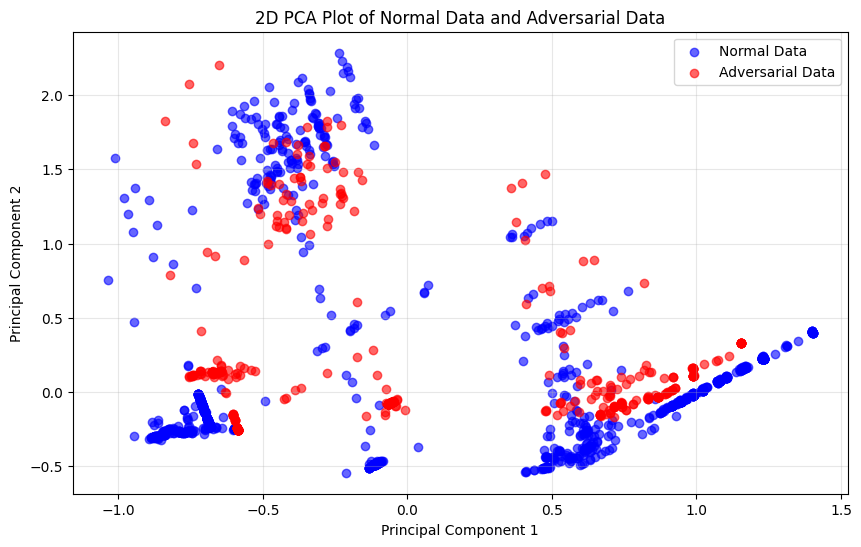

In [ ]:
import functions.visualizer as visualizer
import importlib
importlib.reload(visualizer)

visualizer.visualize_data_distribution(X_train, 'Normal Data', X_adv_fgsm_df, 'Adversarial Data')

## Explainer

In [7]:
import functions.explainer as exp
import importlib
importlib.reload(exp)

explainer = exp.generate_shap_explainer(ids_model, X_train)

shap_values = exp.generate_shap_values(explainer, X_train)
print(shap_values.shape)
shap_values_df = exp.convert_shap_values_to_pd(shap_values, X_train.columns)

shap_values_adv = exp.generate_shap_values(explainer, X_adv_fgsm)
print(shap_values_adv.shape)
shap_values_adv_df = exp.convert_shap_values_to_pd(shap_values_adv, X_train.columns)

PermutationExplainer explainer: 1601it [01:52, 13.46it/s]                          


(1600, 70)


PermutationExplainer explainer: 1601it [01:41, 14.42it/s]                          

(1600, 70)


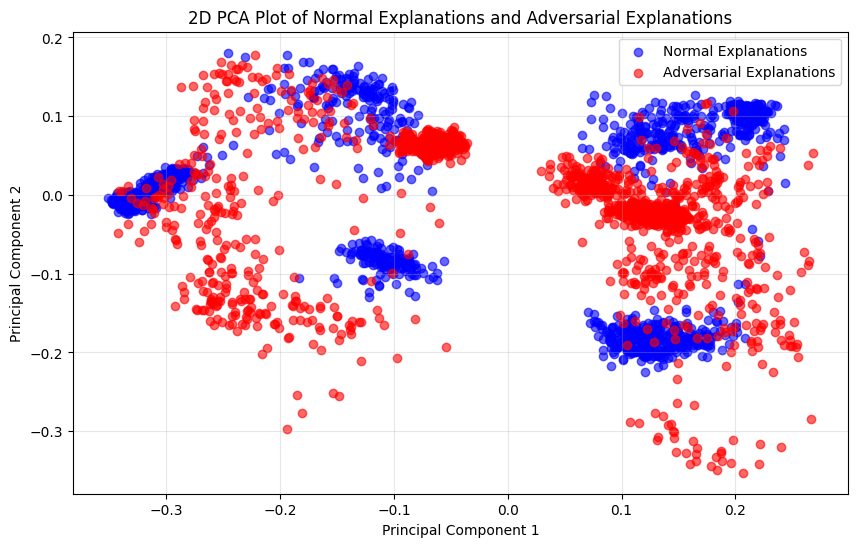

In [25]:
visualizer.visualize_data_distribution(shap_values_df, 'Normal Explanations', shap_values_adv_df, 'Adversarial Explanations')

## Detector

In [8]:
import functions.detector as det
import importlib
importlib.reload(det)
import numpy as np

# create dataframe
X, y = det.build_train_datasets(shap_values_df, shap_values_adv_df)
print(X.shape, y.shape)

# create normalizer
# normalizer = det.create_min_max_normalizer(X)
# print(np.max(normalizer.data_max_))
# print(np.min(normalizer.data_min_))

# TODO: how to normalize? min/max should be consistent for all datasets
# normalize features
# X = normalizer.transform(X)
# print(np.max(X))
# print(np.min(X))

# split data
X_train_det, X_test_det, y_train_det, y_test_det = train_test_split(X, y, test_size=0.1, random_state=1503)
print(X_train_det.shape, X_test_det.shape, y_train_det.shape, y_test_det.shape)

# build detector
detector = det.build_detector(X_train_det, y_train_det, X_test_det, y_test_det)


# normalizer_adv = det.create_min_max_normalizer(shap_values_adv_df)
# print(np.max(normalizer_adv.data_max_))
# print(np.min(normalizer_adv.data_min_))

# shap_values_normalized = det.normalize_shap_values(shap_values_df)
# print(shap_values_normalized.shape)
# print(np.max(shap_values_normalized))
# print(np.min(shap_values_normalized))

(3200, 70) (3200, 2)
(2880, 70) (320, 70) (2880, 2) (320, 2)
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6366 - loss: 0.6915 - val_accuracy: 0.8698 - val_loss: 0.6848
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8156 - loss: 0.6814 - val_accuracy: 0.8333 - val_loss: 0.6671
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8303 - loss: 0.6614 - val_accuracy: 0.8333 - val_loss: 0.6298
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8446 - loss: 0.6158 - val_accuracy: 0.8455 - val_loss: 0.5580
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8820 - loss: 0.5386 - val_accuracy: 0.8767 - val_loss: 0.4557
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9176 - loss: 0.4368 - val_accuracy: 0.9601 - val_loss: 0.3487
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9490 - loss: 0.3434 - val_accuracy: 0.9774 - val_loss: 0.2507
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accur

---
## Test Process

In [9]:
print(X_test.shape)

(400, 70)


### Generate Attacks

In [10]:
X_test_adv = ag.generate_fgsm_attacks(art_model, X_test)

Adversarial FGSM examples generated. Shape: (400, 70)


### Generate Explanations

In [11]:
X_test_adv_shap_values = exp.generate_shap_values(explainer, X_test_adv)
X_test_shap_values = exp.generate_shap_values(explainer, X_test)
X_test_shap_values_df = exp.convert_shap_values_to_pd(X_test_shap_values, X_test.columns)
X_test_adv_shap_values_df = exp.convert_shap_values_to_pd(X_test_adv_shap_values, X_test.columns)

PermutationExplainer explainer: 401it [00:24,  9.78it/s]                         
PermutationExplainer explainer: 401it [00:27,  9.31it/s]                         


### Generate Datasets

In [12]:
X, y = det.build_train_datasets(X_test_shap_values_df, X_test_adv_shap_values_df)

### Preprocess Data

In [13]:
# print(np.max(X))
# print(np.min(X))
# X = normalizer.transform(X)
# print(np.max(X))
# print(np.min(X))

### Shuffle Data & Predict

In [14]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=187)

y_pred = detector.predict(X)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


### Evaluate

In [15]:
det.evaluate_model(y_pred, y)

Global Accuracy: 98.25%
              precision    recall  f1-score   support

      BENIGN       0.98      0.98      0.98       400
 ADVERSARIAL       0.98      0.98      0.98       400

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800

True Negative Rate: 98.25%
False Positive Rate: 1.75%
True Positive Rate: 98.25%
False Negative Rate: 1.75%


---
## Additional Evaluation - New Samples

In [30]:
import functions.data_preprocessing as dp
import importlib
importlib.reload(dp)

X_eval, y_eval = dp.preprocess_data(dataset, encoding_type, normalizer, zero_columns, sample_size=250, random_sample_state=187)
print(y_eval.value_counts())

-- Preprocessing data --
--- Sampling balanced data ---
Sample to shape: (500, 79)
--- Splitting labels and features ---
--- Encoding labels as binary one-hot values ---
--- Normalizing features using MinMaxScaler ---
BENIGN  ATTACK
False   True      250
True    False     250
Name: count, dtype: int64


In [31]:
X_adv_fgsm_eval = ag.generate_fgsm_attacks(art_model, X_eval)
print(X_adv_fgsm.iloc[:, :3].head(2))

ag.evaluate_art_model(art_model, X_adv_fgsm_eval, y_eval)

Adversarial FGSM examples generated. Shape: (500, 70)
   Destination Port  Flow Duration  Total Fwd Packets
0          0.790196            0.1                0.1
1          0.000000            0.1                0.1
Accuracy: 0.248
              precision    recall  f1-score   support

      BENIGN       0.24      0.23      0.24       250
      ATTACK       0.26      0.26      0.26       250

   micro avg       0.25      0.25      0.25       500
   macro avg       0.25      0.25      0.25       500
weighted avg       0.25      0.25      0.25       500
 samples avg       0.25      0.25      0.25       500

Confusion Matrix: Positive == BENIGN
TN: 66, FP: 184, FN: 192, TP: 58


0.248

In [18]:
X_eval_adv_shap_values = exp.generate_shap_values(explainer, X_adv_fgsm_eval)
X_eval_shap_values = exp.generate_shap_values(explainer, X_eval)
X_eval_shap_values_df = exp.convert_shap_values_to_pd(X_eval_shap_values, X_eval.columns)
X_eval_adv_shap_values_df = exp.convert_shap_values_to_pd(X_eval_adv_shap_values, X_eval.columns)

PermutationExplainer explainer: 501it [00:31, 10.56it/s]                         
PermutationExplainer explainer: 501it [00:34, 10.42it/s]                         


In [19]:
X_eval_detector, y_eval_detector = det.build_train_datasets(X_eval_shap_values_df, X_eval_adv_shap_values_df)
print(X_eval_detector.shape, y_eval_detector.shape)

(1000, 70) (1000, 2)


In [20]:
from sklearn.utils import shuffle

X_eval_detector, y_eval_detector = shuffle(X_eval_detector, y_eval_detector, random_state=187)

y_pred_eval_detector = detector.predict(X_eval_detector)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [21]:
det.evaluate_model(y_pred_eval_detector, y_eval_detector)

Global Accuracy: 97.80%
              precision    recall  f1-score   support

      BENIGN       0.99      0.97      0.98       500
 ADVERSARIAL       0.97      0.99      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

True Negative Rate: 97.00%
False Positive Rate: 3.00%
True Positive Rate: 98.60%
False Negative Rate: 1.40%
